# Image Classifier

Here we will combine previous techniques into a model that can classify images given a corresponding training dataset.
We will construct a network of layers to process training data and make predictions on new unseen data.

The network will apply filters and transformations to identify patterns in data and connect those patterns (or features) to an output class via loss function.

Mathematically, we assign each class an integer.  When a training image is processed, a vector of values is output.  These values are compared to the ground truth (the true class of the image) and the error (or divergence from truth) is backpropagated through the network.  This back propogation has the effect of tuning the network in a way such that if that same image were process by the network again, a score closer to the ground truth will be output by the network.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(f'numpy version: {np.__version__}')
print(f'torch version: {torch.__version__}')
print(f'torch vision version: {torchvision.__version__}')


numpy version: 1.26.0
torch version: 2.1.1
torch vision version: 0.16.1


Data Loading into pytorch DataLoaders

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=6,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=6,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


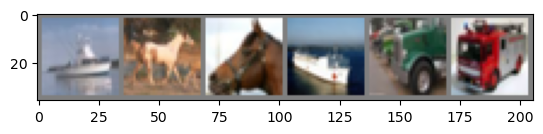

 ship horse horse  ship truck truck


In [4]:


# Define transformations (apply to ALL data entering model)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Get the batches with iter
images, labels = next(iter(trainloader))


# Preview Data
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Inpect 6 images and their labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(6)))


In [5]:
## Simple Network from pytorch documentation
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
## Refined model with Batch Norm Layers
class newModel(nn.Module):
    def __init__(self):
        super(newModel, self).__init__()
        
        #Define Layers
        self.convLayer1 = nn.Conv2d(in_channels=3,out_channels=32, kernel_size=5)
        self.maxPool1   = nn.MaxPool2d(kernel_size=2,stride=2)
        self.batchNorm1 = nn.BatchNorm2d(num_features=32)

        self.convLayer2 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3)
        self.maxPool2   = nn.MaxPool2d(kernel_size=2,stride=2)
        self.batchNorm2 = nn.BatchNorm2d(num_features=64)

        self.fc1 = nn.Linear(64 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.maxPool1(F.relu(self.batchNorm1(self.convLayer1(x))))
        x = self.maxPool2(F.relu(self.batchNorm2(self.convLayer2(x))))
        x = x.view(-1,64 * 6 * 6) #flattens on last axis
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = newModel()

In [7]:

outputs = net(images)  # Make predictions
print(outputs.shape)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

torch.Size([6, 10])


In [8]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.734
[1,  4000] loss: 1.438
[1,  6000] loss: 1.298
[1,  8000] loss: 1.220
[2,  2000] loss: 1.123
[2,  4000] loss: 1.087
[2,  6000] loss: 1.051
[2,  8000] loss: 1.021
[3,  2000] loss: 0.937
[3,  4000] loss: 0.923
[3,  6000] loss: 0.896
[3,  8000] loss: 0.902
[4,  2000] loss: 0.813
[4,  4000] loss: 0.809
[4,  6000] loss: 0.803
[4,  8000] loss: 0.801
[5,  2000] loss: 0.695
[5,  4000] loss: 0.727
[5,  6000] loss: 0.731
[5,  8000] loss: 0.741
Finished Training


In [9]:
PATH = './model2_net.pth'
torch.save(net.state_dict(), PATH)

In [10]:
#PATH = './cifar_net.pth'
##state_dict = torch.load(PATH)
#net.load_state_dict(state_dict)

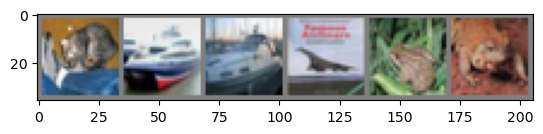

  cat  ship  ship airplane  frog  frog


In [11]:



# Get the first batch (containing the first 4 images and labels)
images, labels = next(iter(testloader))

# Define a function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display the first 6 images and their labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(6)))

In [12]:
outputs = net(images)

In [13]:


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(6)))



Predicted:    cat  ship  ship plane  frog  frog


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 70 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 77 %
Accuracy of   car : 71 %
Accuracy of  bird : 63 %
Accuracy of   cat : 53 %
Accuracy of  deer : 72 %
Accuracy of   dog : 55 %
Accuracy of  frog : 76 %
Accuracy of horse : 79 %
Accuracy of  ship : 82 %
Accuracy of truck : 76 %


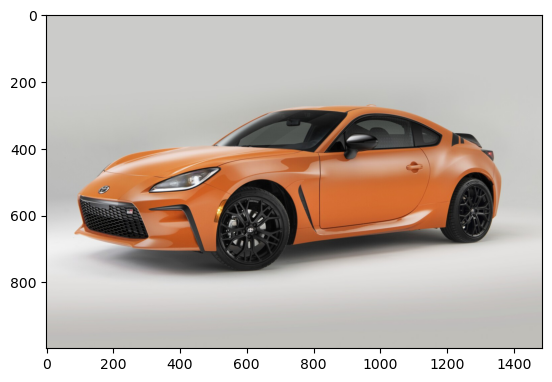

In [16]:
from PIL import Image
import torchvision.transforms as transforms

image_path = 'data\car1.jpeg'
image = Image.open(image_path)
plt.imshow(image)

In [17]:
from PIL import Image
import torchvision.transforms as transforms


image_path = 'data\car1.jpeg'
image = Image.open(image_path)

# Define transformations to preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to match the input size of your model
    transforms.ToTensor(),        # Convert image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Apply same transformations to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension (batch_size=1)

# eval mode so weights are not updated
net.eval()

# access the model without modifying gradients
with torch.no_grad():
    outputs = net(input_image)

# Get the prediction
_, predicted = torch.max(outputs, 1)

print("Predicted class:", trainset.classes[predicted.item()])




Predicted class: automobile
